In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Q5 load pre trained faster rcnn

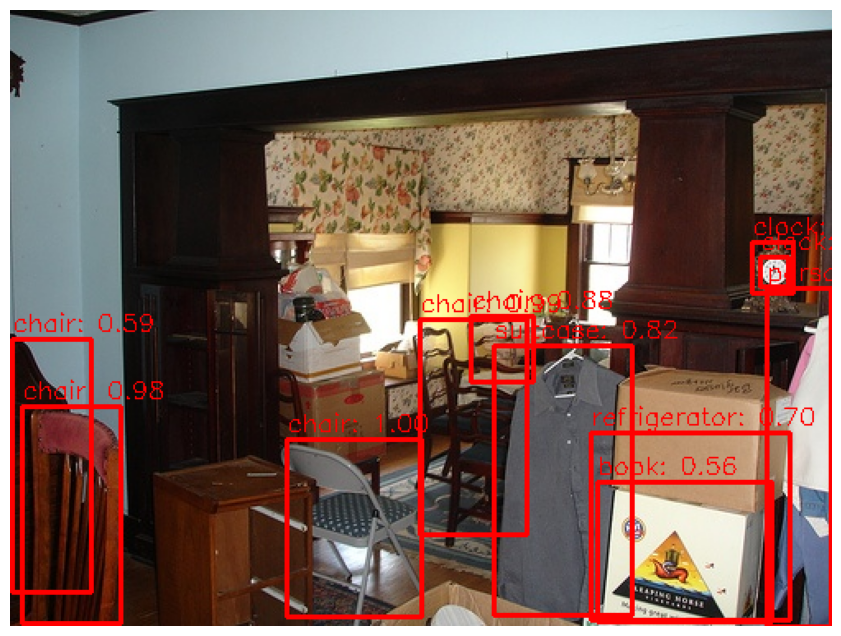

In [8]:
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Load pre-trained COCO model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Load image
image_path = "/kaggle/input/pascal-voc-2007-dataset/VOCdevkit2007/VOC2007/JPEGImages/000005.jpg"
image = Image.open(image_path).convert("RGB")
img_tensor = torchvision.transforms.functional.to_tensor(image)

# Predict
with torch.no_grad():
    predictions = model([img_tensor])[0]

# COCO class names (91 classes)
coco_classes = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
    'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A',
    'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Visualize with bounding boxes
img = np.array(image)
for box, label, score in zip(predictions['boxes'], predictions['labels'], predictions['scores']):
    if score > 0.5:  # Confidence threshold
        box = [int(coord) for coord in box]
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (255,0,0), 2)
        cv2.putText(img, f"{coco_classes[label]}: {score:.2f}", 
                   (box[0], box[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)

plt.figure(figsize=(12,8))
plt.imshow(img)
plt.axis('off')
plt.show()

Q6 Fine-tuning Faster R-CNN on a Custom Dataset 

In [2]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD
import numpy as np
from tqdm import tqdm
import os
import xml.etree.ElementTree as ET
from PIL import Image
import torchvision.transforms as T

# VOC Dataset Class
class VOCDataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, "JPEGImages")
        self.annotation_dir = os.path.join(root_dir, "Annotations")
        self.split = split
        self.transform = transform
        
        # Define Pascal VOC classes
        self.classes = [
            '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
            'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog',
            'horse', 'motorbike', 'person', 'pottedplant', 'sheep',
            'sofa', 'train', 'tvmonitor'
        ]
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        
        # Read image filenames
        split_file = os.path.join(root_dir, "ImageSets", "Main", f"{split}.txt")
        with open(split_file, "r") as f:
            self.image_filenames = [line.strip() for line in f.readlines()]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        filename = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, f"{filename}.jpg")
        ann_path = os.path.join(self.annotation_dir, f"{filename}.xml")

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Parse annotation
        tree = ET.parse(ann_path)
        root = tree.getroot()

        boxes = []
        labels = []
        for obj in root.findall("object"):
            class_name = obj.find("name").text.lower()
            if class_name not in self.class_to_idx:
                continue
                
            bbox = obj.find("bndbox")
            boxes.append([
                int(bbox.find("xmin").text),
                int(bbox.find("ymin").text),
                int(bbox.find("xmax").text),
                int(bbox.find("ymax").text)
            ])
            labels.append(self.class_to_idx[class_name])

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

        if self.transform:
            image = self.transform(image)

        return image, target

# Data Loader Function
def get_data_loaders(root_dir, batch_size=4):
    transform = T.Compose([T.ToTensor()])
    
    # Create datasets
    train_dataset = VOCDataset(
        root_dir=root_dir,
        split="train",
        transform=transform
    )
    
    val_dataset = VOCDataset(
        root_dir=root_dir,
        split="val",
        transform=transform
    )

    # Create data loaders
    def collate_fn(batch):
        return tuple(zip(*batch))

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn
    )

    return train_loader, val_loader

# Training Function
def train_model(train_loader, val_loader, num_classes=21, 
                lr=0.005, batch_size=4, num_epochs=1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Replace classifier head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # Freeze backbone layers
    for param in model.backbone.parameters():
        param.requires_grad = False
        
    model.to(device)
    
    # Optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        
        for images, targets in tqdm(train_loader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            epoch_loss += losses.item()
        
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss/len(train_loader):.4f}")
    
    return model

# Main execution
if __name__ == "__main__":
    # Set dataset path
    dataset_root = "/kaggle/input/pascal-voc-2007-dataset/VOCdevkit2007/VOC2007"
    
    # Get data loaders
    train_loader, val_loader = get_data_loaders(
        root_dir=dataset_root,
        batch_size=4
    )
    
    # Train model
    trained_model = train_model(
        train_loader,
        val_loader,
        num_epochs=1
    )


100%|██████████| 626/626 [03:44<00:00,  2.79it/s]

Epoch 1/1 | Train Loss: 0.4375


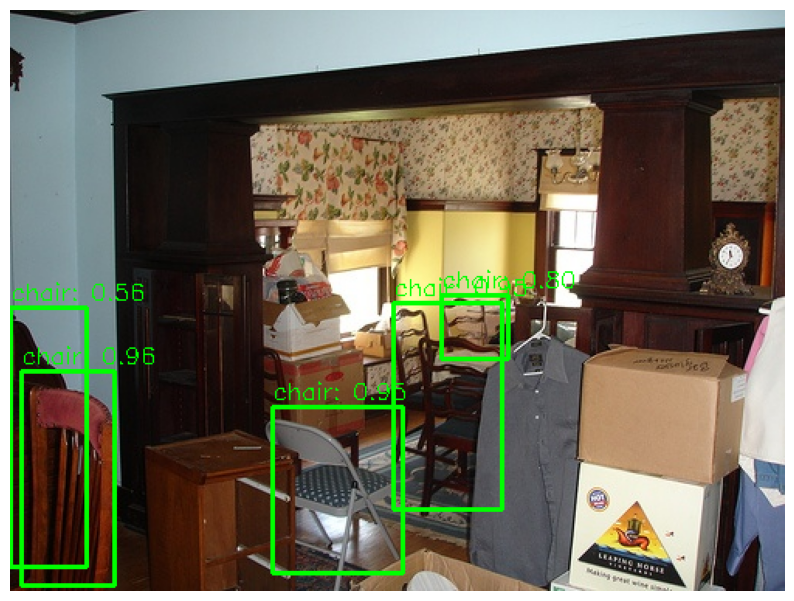

In [18]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T

# Define VOC classes
voc_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog',
    'horse', 'motorbike', 'person', 'pottedplant', 'sheep',
    'sofa', 'train', 'tvmonitor'
]

# Load image and run inference
def visualize_image_prediction(model, image_path, threshold=0.5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device).eval()

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([T.ToTensor()])
    image_tensor = transform(image).to(device)

    # Run model inference
    with torch.no_grad():
        prediction = model([image_tensor])[0]

    # Convert tensor image to numpy
    img = np.array(image)
    
    # Draw bounding boxes
    for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
        if score > threshold:
            box = box.int().cpu().numpy()
            label_name = voc_classes[label]
            color = (0, 255, 0)  # Green color for boxes
            cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color, 2)
            cv2.putText(img, f"{label_name}: {score:.2f}", 
                        (box[0], box[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    # Show image
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Run on given image
image_path = "/kaggle/input/pascal-voc-2007-dataset/VOCdevkit2007/VOC2007/JPEGImages/000005.jpg"
visualize_image_prediction(trained_model, image_path)
